In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from PIL import Image
from tqdm import tqdm  # for progress bar (optional)
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
!pip install torchsummary
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import models

from sklearn.metrics import jaccard_score as compute_iou
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Data Loader**

In [2]:
class ISIC2016Dataset(Dataset):
    def __init__(self, root_dir, split='train', val_size=0.2):
        self.root_dir = root_dir
        self.split = split
        self.transform =  transforms.Compose([
                          transforms.Resize((128, 128)),
                          transforms.ToTensor()])
        
        self.images_dir = os.path.join(root_dir, 'train')
        self.masks_dir = os.path.join(root_dir, 'train_masks')
        self.test_images_dir = os.path.join(root_dir, 'test')
        self.test_masks_dir = os.path.join(root_dir, 'test_masks')

        if split == 'train':
            self.images = os.listdir(self.images_dir)
            self.images, _, self.masks, _ = train_test_split(self.images, self.images, test_size=val_size, random_state=42)
        elif split == 'validation':
            self.images = os.listdir(self.images_dir)
            _, self.images, _, self.masks = train_test_split(self.images, self.images, test_size=val_size, random_state=42)
        elif split == 'test':
            self.images = os.listdir(self.test_images_dir)
            self.masks = self.images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        if (self.split == 'train') or (self.split == 'validation'):
            img_name = os.path.join(self.images_dir, self.images[idx])
            mask_name = os.path.join(self.masks_dir, self.masks[idx])
            mask_name = mask_name[:-3]+'png'
 
        elif self.split == 'test':
            img_name = os.path.join(self.test_images_dir, self.images[idx])
            mask_name = os.path.join(self.test_masks_dir, self.masks[idx])
            mask_name = mask_name[:-3]+'png'

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [65]:
train_dataset = ISIC2016Dataset('/kaggle/input/isic-2016-skin-cancer-segmentation/ISIC 2016', split='train')
validation_dataset = ISIC2016Dataset('/kaggle/input/isic-2016-skin-cancer-segmentation/ISIC 2016', split='validation')
test_dataset = ISIC2016Dataset('/kaggle/input/isic-2016-skin-cancer-segmentation/ISIC 2016', split='test')

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers = 4)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers = 4)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers = 4)

print(test_dataset[0][1].shape)

torch.Size([1, 128, 128])


In [4]:
def plot_images_and_masks(images, masks):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 2, figsize=(20, 20))

    for i in range(num_images):
        image = np.transpose(images[i].numpy(), (1, 2, 0))
        mask = masks[i].numpy().squeeze()

        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Mask')

    plt.tight_layout()
    plt.show()

In [5]:
print(test_loader)

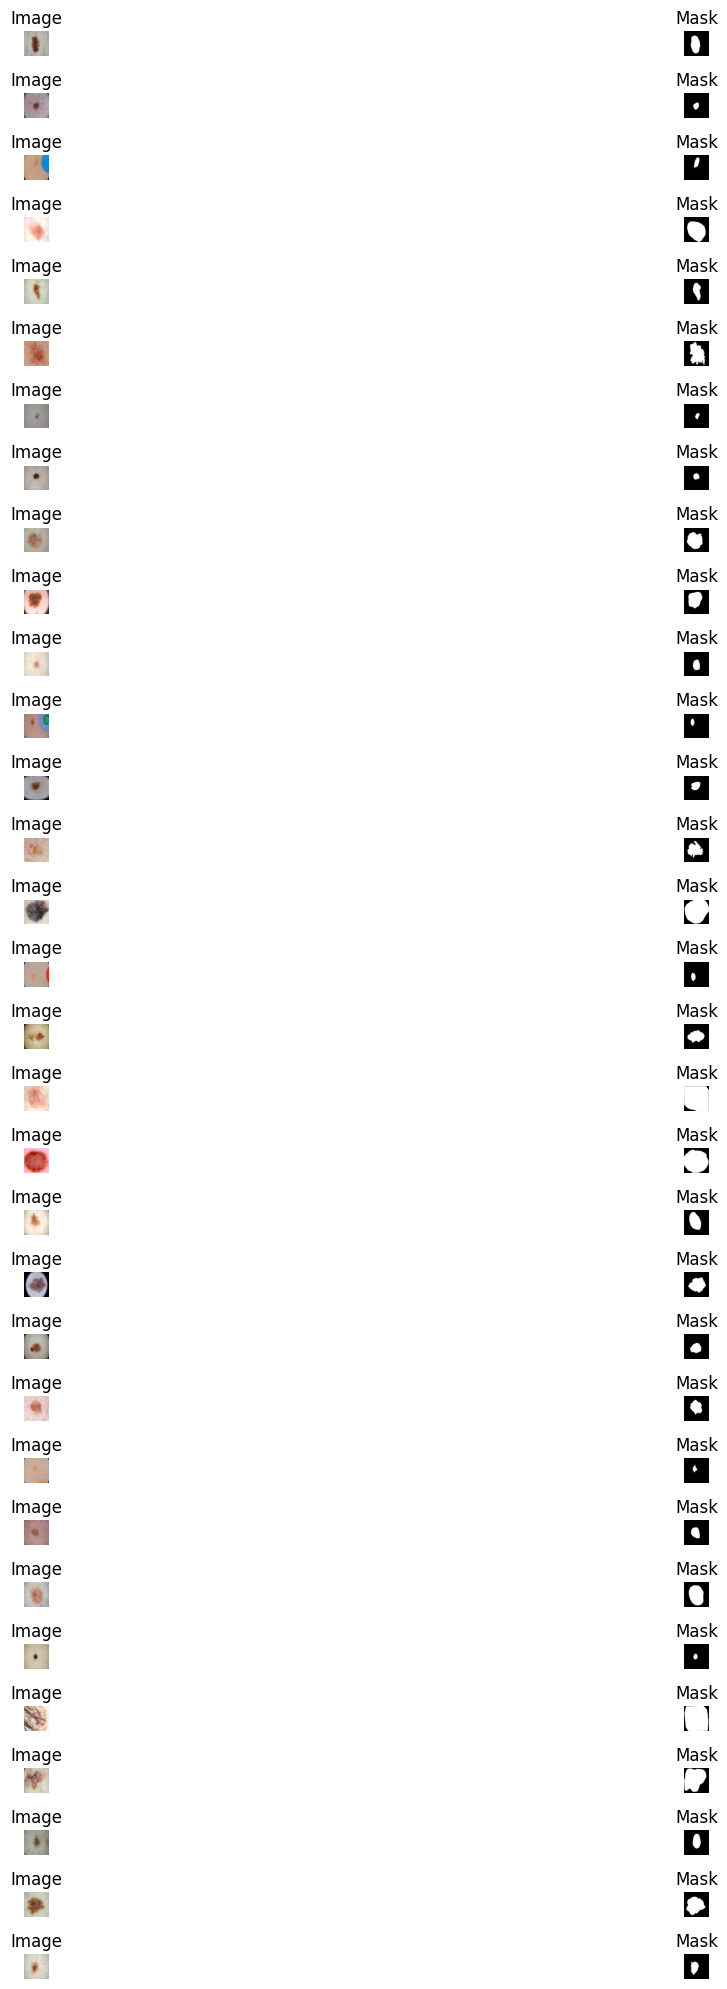

In [6]:
for images, masks in test_loader:
    plot_images_and_masks(images, masks)
    break

# **Plot Few Example Images**

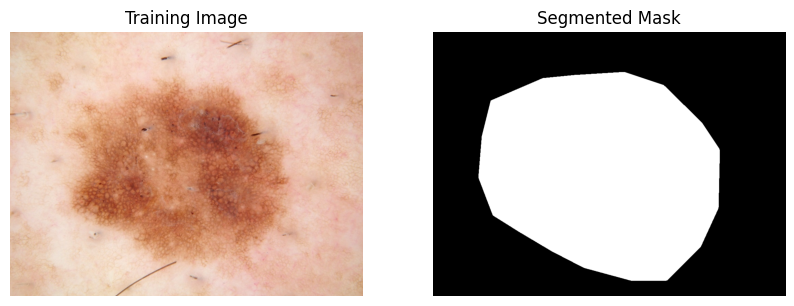

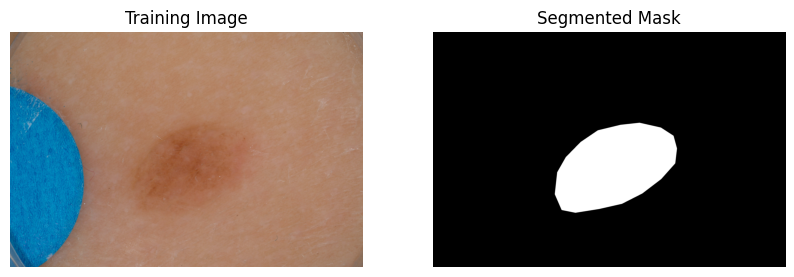

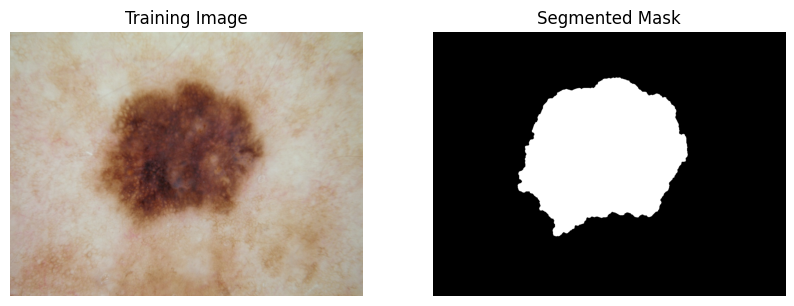

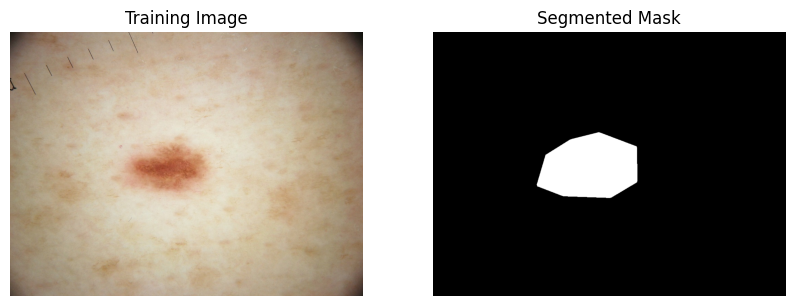

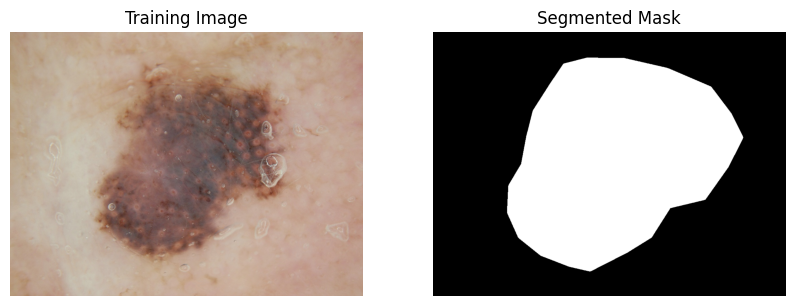

In [7]:
train_folder = '/kaggle/input/isic-2016-skin-cancer-segmentation/ISIC 2016/train'
train_masks_folder = '/kaggle/input/isic-2016-skin-cancer-segmentation/ISIC 2016/train_masks'

train_images = os.listdir(train_folder)

num_images_to_plot = 5
for i in range(num_images_to_plot):
    image_path = os.path.join(train_folder, train_images[i])
    mask_path = os.path.join(train_masks_folder, train_images[i][:-3]+'png')

    # Read images
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    # Display images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Training Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Segmented Mask')
    plt.axis('off')

    plt.show()

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Experiment 1**

In [9]:
encoder = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
encoder = encoder.features

# Freeze encoder parameters
for param in encoder.parameters():
    param.requires_grad = False

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 90.6MB/s]


**Finding Dimensions of Output Data**

In [10]:
i = 0
encoder.to(device)
for image, mask in test_loader:
    image = image.to(device)
    out = encoder(image)
    print(image.shape, out.shape)
    print(type(out))
    break

# out = encoder(image)

torch.Size([32, 3, 128, 128]) torch.Size([32, 1280, 4, 4])
<class 'torch.Tensor'>


In [11]:
summary(encoder, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

## Decoder

In [13]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(DecoderBlock, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv_transpose(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [90]:
class CustomAutoEncoder(nn.Module):
    def __init__(self, encoder):
        super(CustomAutoEncoder, self).__init__()
        self.encoder = encoder
        
        self.activation = {}
        def get_activation(idx):
            def hook(encoder, input, output):
                self.activation[idx] = output.detach()
            return hook

        # Register hooks for the desired layers
        
        idxs = [17, 15, 9, 5, 0]
        for i in idxs:
            self.encoder[i].register_forward_hook(get_activation(i))
        
        # Define decoder blocks
        self.dec1 = DecoderBlock(1280, 320, 1, 1)
        self.dec2 = DecoderBlock(320, 160, 1, 1)
        self.dec3 = DecoderBlock(160, 576, 2, 2)
        self.dec4 = DecoderBlock(576, 384, 1, 1)
        self.dec5 = DecoderBlock(384, 64, 1, 1)
        self.dec6 = DecoderBlock(64, 192, 2, 2)
        self.dec7 = DecoderBlock(192, 32, 1, 1)
        self.dec8 = DecoderBlock(32, 144, 2, 2)
        self.dec9 = DecoderBlock(144, 96, 2, 2)
        self.dec10 = DecoderBlock(96, 32, 1, 1)
        self.dec11 = DecoderBlock(32, 1, 2, 2)  # Final layer for 1 channel output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        x = self.encoder(x)  # Pass input through the encoder
        

        # Pass the encoded features through each decoder block sequentially
        x = self.dec1(x)
        x = self.dec2(x + self.activation[17])
        x = self.dec3(x + self.activation[15])
        x = self.dec4(x)
        x = self.dec5(x)
        x = self.dec6(x + self.activation[9])
        x = self.dec7(x)
        x = self.dec8(x + self.activation[5])
        x = self.dec9(x)
        x = self.dec10(x)
        x = self.dec11(x + self.activation[0])
        x = self.sigmoid(x)
        return x

In [91]:
activation = {}
def get_activation(idx):
    def hook(module, input, output):
        activation[idx] = output.detach()
    return hook

# Register hooks for the desired layers
for i in range(18):
    encoder[i].register_forward_hook(get_activation(i))
    
x = torch.randn(1, 3, 128, 128)
x = x.to(device)

output = encoder(x)
    
for i in range(18):
    print(activation[i].shape, i)

# print(encoder)

torch.Size([1, 32, 64, 64]) 0
torch.Size([1, 16, 64, 64]) 1
torch.Size([1, 24, 32, 32]) 2
torch.Size([1, 24, 32, 32]) 3
torch.Size([1, 32, 16, 16]) 4
torch.Size([1, 32, 16, 16]) 5
torch.Size([1, 32, 16, 16]) 6
torch.Size([1, 64, 8, 8]) 7
torch.Size([1, 64, 8, 8]) 8
torch.Size([1, 64, 8, 8]) 9
torch.Size([1, 64, 8, 8]) 10
torch.Size([1, 96, 8, 8]) 11
torch.Size([1, 96, 8, 8]) 12
torch.Size([1, 96, 8, 8]) 13
torch.Size([1, 160, 4, 4]) 14
torch.Size([1, 160, 4, 4]) 15
torch.Size([1, 160, 4, 4]) 16
torch.Size([1, 320, 4, 4]) 17


In [41]:
dummy = nn.Sequential(
    DecoderBlock(1280, 320, 1, 1),
    DecoderBlock(320, 160, 1, 1),
    DecoderBlock(160, 576, 2, 2),
    DecoderBlock(576, 384, 1, 1),
    DecoderBlock(384, 96, 1, 1),
    DecoderBlock(96, 64, 1, 1),
    DecoderBlock(64, 192, 2, 2),
    DecoderBlock(192, 32, 1, 1),
    DecoderBlock(32, 24, 2, 2),
    DecoderBlock(24, 96, 2, 2),
    DecoderBlock(96, 32, 1, 1),
    DecoderBlock(32, 1, 2, 2)
)

dummy.to(device)

summary(dummy, (1280, 4, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 320, 4, 4]         409,920
       BatchNorm2d-2            [-1, 320, 4, 4]             640
              ReLU-3            [-1, 320, 4, 4]               0
      DecoderBlock-4            [-1, 320, 4, 4]               0
   ConvTranspose2d-5            [-1, 160, 4, 4]          51,360
       BatchNorm2d-6            [-1, 160, 4, 4]             320
              ReLU-7            [-1, 160, 4, 4]               0
      DecoderBlock-8            [-1, 160, 4, 4]               0
   ConvTranspose2d-9            [-1, 576, 8, 8]         369,216
      BatchNorm2d-10            [-1, 576, 8, 8]           1,152
             ReLU-11            [-1, 576, 8, 8]               0
     DecoderBlock-12            [-1, 576, 8, 8]               0
  ConvTranspose2d-13            [-1, 384, 8, 8]         221,568
      BatchNorm2d-14            [-1, 38

In [98]:
segmentation_model = CustomAutoEncoder(encoder)
segmentation_model.to(device)
print('Model Prepared')

Model Prepared


## Training Loop

In [71]:
def compute_iou(y_pred, y_true):
    # Implement your IoU calculation logic here
    # This is a basic example using torch.sum
    intersection = torch.sum(y_pred * y_true)
    union = torch.sum(y_pred) + torch.sum(y_true) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)  # Add small epsilon for stability
    return iou.mean()

def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

In [99]:
# Hyperparameters (adjust as needed)
learning_rate = 0.001
epochs = 40

# Loss function (assuming pixel-wise binary cross entropy)
criterion = nn.BCELoss()

# Optimizer
optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=learning_rate, weight_decay=0.00001)

# Training loop
train_iou_history = []
val_iou_history = []

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    print(f"\nEpoch: {epoch+1}/{epochs}")

    # Train loop
    segmentation_model.train()
    train_loss = 0
    train_iou = 0
    for images, masks in tqdm(train_loader):  # Use tqdm for progress bar (optional)
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = segmentation_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += compute_iou(outputs, masks)
    train_loss_history.append(train_loss/len(train_loader))
    train_iou_history.append(float(train_iou/len(train_loader)))
    print('Train Loss:', round(train_loss_history[epoch], 2), 'Train IoU:', round(train_iou_history[epoch], 2))

    # Validation loop
    segmentation_model.eval()
    val_loss = 0
    val_iou = 0
    with torch.no_grad():
        for images, masks in validation_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = segmentation_model(images)
            val_loss += criterion(outputs, masks).item()
            val_iou += compute_iou(outputs, masks)
    val_loss_history.append(val_loss/len(validation_loader))
    val_iou_history.append(float(val_iou/len(validation_loader)))
    print('Validation Loss:', round(val_loss_history[epoch], 2), 'Validation IoU:', round(val_iou_history[epoch], 2))



Epoch: 1/40


100%|██████████| 12/12 [00:15<00:00,  1.27s/it]

Train Loss: 0.72 Train IoU: 0.24


Validation Loss: 0.71 Validation IoU: 0.23

Epoch: 2/40


100%|██████████| 12/12 [00:15<00:00,  1.29s/it]

Train Loss: 0.65 Train IoU: 0.26


Validation Loss: 0.67 Validation IoU: 0.26

Epoch: 3/40


100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Train Loss: 0.63 Train IoU: 0.28


Validation Loss: 0.64 Validation IoU: 0.29

Epoch: 4/40


100%|██████████| 12/12 [00:15<00:00,  1.27s/it]

Train Loss: 0.62 Train IoU: 0.3


Validation Loss: 0.63 Validation IoU: 0.3

Epoch: 5/40


100%|██████████| 12/12 [00:14<00:00,  1.21s/it]

Train Loss: 0.61 Train IoU: 0.3


Validation Loss: 0.62 Validation IoU: 0.3

Epoch: 6/40


100%|██████████| 12/12 [00:14<00:00,  1.19s/it]

Train Loss: 0.6 Train IoU: 0.31


Validation Loss: 0.62 Validation IoU: 0.3

Epoch: 7/40


100%|██████████| 12/12 [00:15<00:00,  1.27s/it]

Train Loss: 0.6 Train IoU: 0.31


Validation Loss: 0.62 Validation IoU: 0.3

Epoch: 8/40


100%|██████████| 12/12 [00:14<00:00,  1.23s/it]

Train Loss: 0.6 Train IoU: 0.32


Validation Loss: 0.61 Validation IoU: 0.31

Epoch: 9/40


100%|██████████| 12/12 [00:15<00:00,  1.25s/it]

Train Loss: 0.6 Train IoU: 0.32


Validation Loss: 0.61 Validation IoU: 0.31

Epoch: 10/40


100%|██████████| 12/12 [00:14<00:00,  1.22s/it]

Train Loss: 0.59 Train IoU: 0.32


Validation Loss: 0.62 Validation IoU: 0.32

Epoch: 11/40


100%|██████████| 12/12 [00:14<00:00,  1.25s/it]

Train Loss: 0.59 Train IoU: 0.32


Validation Loss: 0.61 Validation IoU: 0.31

Epoch: 12/40


100%|██████████| 12/12 [00:15<00:00,  1.26s/it]

Train Loss: 0.59 Train IoU: 0.33


Validation Loss: 0.61 Validation IoU: 0.31

Epoch: 13/40


100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Train Loss: 0.58 Train IoU: 0.33


Validation Loss: 0.6 Validation IoU: 0.33

Epoch: 14/40


100%|██████████| 12/12 [00:15<00:00,  1.27s/it]

Train Loss: 0.58 Train IoU: 0.34


Validation Loss: 0.6 Validation IoU: 0.34

Epoch: 15/40


100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Train Loss: 0.57 Train IoU: 0.34


Validation Loss: 0.59 Validation IoU: 0.34

Epoch: 16/40


100%|██████████| 12/12 [00:15<00:00,  1.26s/it]

Train Loss: 0.56 Train IoU: 0.35


Validation Loss: 0.59 Validation IoU: 0.34

Epoch: 17/40


100%|██████████| 12/12 [00:14<00:00,  1.25s/it]

Train Loss: 0.56 Train IoU: 0.35


Validation Loss: 0.59 Validation IoU: 0.35

Epoch: 18/40


100%|██████████| 12/12 [00:15<00:00,  1.29s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.58 Validation IoU: 0.34

Epoch: 19/40


100%|██████████| 12/12 [00:15<00:00,  1.26s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.59 Validation IoU: 0.34

Epoch: 20/40


100%|██████████| 12/12 [00:16<00:00,  1.37s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.59 Validation IoU: 0.35

Epoch: 21/40


100%|██████████| 12/12 [00:16<00:00,  1.35s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.59 Validation IoU: 0.36

Epoch: 22/40


100%|██████████| 12/12 [00:15<00:00,  1.32s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.59 Validation IoU: 0.35

Epoch: 23/40


100%|██████████| 12/12 [00:16<00:00,  1.36s/it]

Train Loss: 0.55 Train IoU: 0.36


Validation Loss: 0.58 Validation IoU: 0.36

Epoch: 24/40


100%|██████████| 12/12 [00:15<00:00,  1.32s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.58 Validation IoU: 0.35

Epoch: 25/40


100%|██████████| 12/12 [00:15<00:00,  1.32s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.58 Validation IoU: 0.35

Epoch: 26/40


100%|██████████| 12/12 [00:16<00:00,  1.35s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.59 Validation IoU: 0.36

Epoch: 27/40


100%|██████████| 12/12 [00:15<00:00,  1.33s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.59 Validation IoU: 0.36

Epoch: 28/40


100%|██████████| 12/12 [00:15<00:00,  1.31s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.58 Validation IoU: 0.36

Epoch: 29/40


100%|██████████| 12/12 [00:15<00:00,  1.33s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.58 Validation IoU: 0.36

Epoch: 30/40


100%|██████████| 12/12 [00:16<00:00,  1.34s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.58 Validation IoU: 0.36

Epoch: 31/40


100%|██████████| 12/12 [00:15<00:00,  1.32s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.59 Validation IoU: 0.37

Epoch: 32/40


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.58 Validation IoU: 0.36

Epoch: 33/40


100%|██████████| 12/12 [00:15<00:00,  1.28s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.58 Validation IoU: 0.36

Epoch: 34/40


100%|██████████| 12/12 [00:15<00:00,  1.31s/it]

Train Loss: 0.54 Train IoU: 0.38


Validation Loss: 0.58 Validation IoU: 0.36

Epoch: 35/40


100%|██████████| 12/12 [00:15<00:00,  1.29s/it]

Train Loss: 0.54 Train IoU: 0.38


Validation Loss: 0.59 Validation IoU: 0.37

Epoch: 36/40


100%|██████████| 12/12 [00:15<00:00,  1.25s/it]

Train Loss: 0.54 Train IoU: 0.38


Validation Loss: 0.58 Validation IoU: 0.36

Epoch: 37/40


100%|██████████| 12/12 [00:15<00:00,  1.29s/it]

Train Loss: 0.54 Train IoU: 0.38


Validation Loss: 0.58 Validation IoU: 0.37

Epoch: 38/40


100%|██████████| 12/12 [00:15<00:00,  1.25s/it]

Train Loss: 0.54 Train IoU: 0.38


Validation Loss: 0.59 Validation IoU: 0.37

Epoch: 39/40


100%|██████████| 12/12 [00:15<00:00,  1.28s/it]

Train Loss: 0.54 Train IoU: 0.38


Validation Loss: 0.58 Validation IoU: 0.37

Epoch: 40/40


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]

Train Loss: 0.54 Train IoU: 0.38


Validation Loss: 0.58 Validation IoU: 0.36


Plots

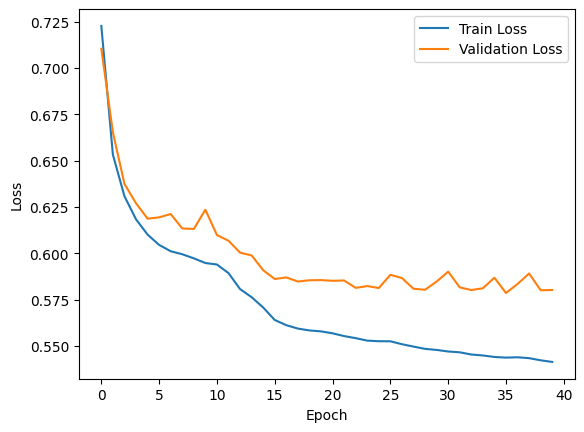

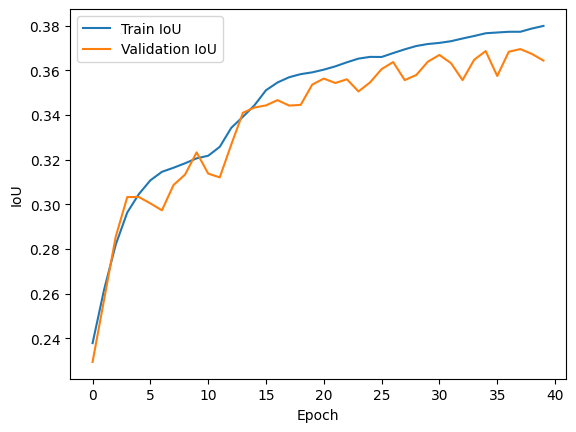

In [100]:
# Optionally, plot the training and validation loss curves
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Optionally, plot the training and validation IoU curves
plt.plot(train_iou_history, label='Train IoU')
plt.plot(val_iou_history, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

## Testing The Model

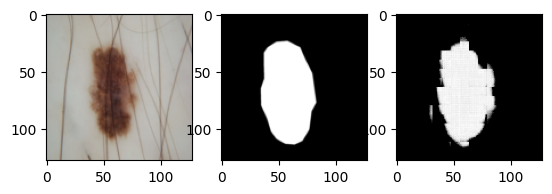

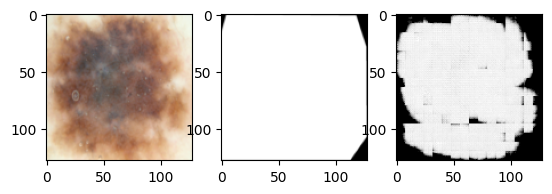

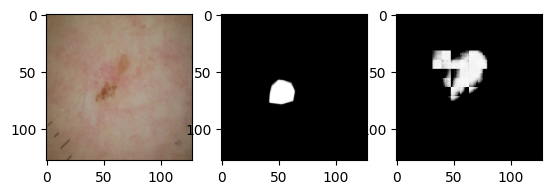

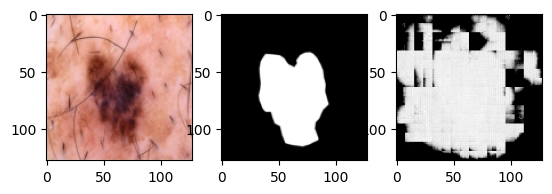

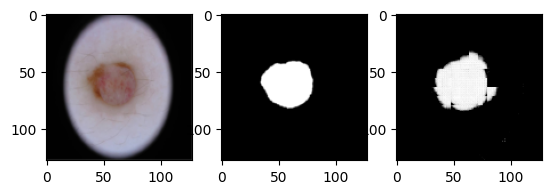

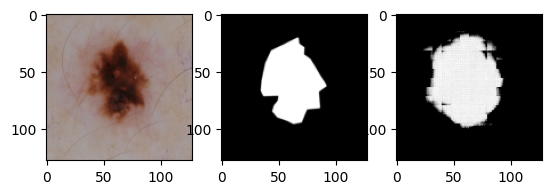

IoU tensor(0.3694, device='cuda:0')
Dice Score tensor(0.5390, device='cuda:0')


In [101]:

segmentation_model.eval()
# evaluate the model on the test data
loss = 0
iou = 0
dice = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = segmentation_model(inputs)
        
        loss += criterion(outputs, labels).item()
        iou += compute_iou(outputs, labels)
        dice += dice_coeff(outputs, labels)

        # visualize the predictions
        fig, axs = plt.subplots(1,3)
        axs[0].imshow(inputs[0].permute(1,2,0).cpu().numpy())
        axs[1].imshow(np.squeeze(labels[0].cpu().numpy()), cmap='gray')
        axs[2].imshow(outputs[0].permute(1,2,0).cpu().numpy(), cmap='gray')
#         print(outputs[0].permute(1,2,0).cpu().numpy().shape)
        plt.show()


# print(''?loss/len(test_loader))
print('IoU', iou/len(test_loader))
print('Dice Score', dice/len(test_loader))

# **Experiment 2**

In [93]:
encoder2 = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
encoder2 = encoder2.features

segmentation_model2 = CustomAutoEncoder(encoder2)
segmentation_model2.to(device)
print('Model Prepared')

Model Prepared


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


## Training Loop

In [94]:
# Hyperparameters (adjust as needed)
learning_rate = 0.001
epochs = 40

# Loss function (assuming pixel-wise binary cross entropy)
criterion = nn.BCELoss()

# Optimizer
optimizer = torch.optim.Adam(segmentation_model2.parameters(), lr=learning_rate, weight_decay=0.00001)

# Training loop
train_iou_history_2 = []
val_iou_history_2 = []

train_loss_history_2 = []
val_loss_history_2 = []

for epoch in range(epochs):
    print(f"\nEpoch: {epoch+1}/{epochs}")

    # Train loop
    segmentation_model2.train()
    train_loss = 0
    train_iou = 0
    for images, masks in tqdm(train_loader):  # Use tqdm for progress bar (optional)
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = segmentation_model2(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += compute_iou(outputs, masks)
    train_loss_history_2.append(train_loss/len(train_loader))
    train_iou_history_2.append(float(train_iou/len(train_loader)))
    print('Train Loss:', round(train_loss_history_2[epoch], 2), 'Train IoU:', round(train_iou_history_2[epoch], 2))

    # Validation loop
    segmentation_model2.eval()
    val_loss = 0
    val_iou = 0
    with torch.no_grad():
        for images, masks in validation_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = segmentation_model2(images)
            val_loss += criterion(outputs, masks).item()
            val_iou += compute_iou(outputs, masks)
    val_loss_history_2.append(val_loss/len(validation_loader))
    val_iou_history_2.append(float(val_iou/len(validation_loader)))
    print('Validation Loss:', round(val_loss_history_2[epoch], 2), 'Validation IoU:', round(val_iou_history_2[epoch], 2))


Epoch: 1/40


100%|██████████| 12/12 [00:15<00:00,  1.27s/it]

Train Loss: 0.68 Train IoU: 0.27


Validation Loss: 0.69 Validation IoU: 0.22

Epoch: 2/40


100%|██████████| 12/12 [00:15<00:00,  1.29s/it]

Train Loss: 0.61 Train IoU: 0.31


Validation Loss: 0.64 Validation IoU: 0.27

Epoch: 3/40


100%|██████████| 12/12 [00:14<00:00,  1.22s/it]

Train Loss: 0.6 Train IoU: 0.32


Validation Loss: 0.6 Validation IoU: 0.32

Epoch: 4/40


100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Train Loss: 0.59 Train IoU: 0.32


Validation Loss: 0.59 Validation IoU: 0.34

Epoch: 5/40


100%|██████████| 12/12 [00:15<00:00,  1.28s/it]

Train Loss: 0.59 Train IoU: 0.33


Validation Loss: 0.58 Validation IoU: 0.35

Epoch: 6/40


100%|██████████| 12/12 [00:15<00:00,  1.26s/it]

Train Loss: 0.58 Train IoU: 0.33


Validation Loss: 0.58 Validation IoU: 0.34

Epoch: 7/40


100%|██████████| 12/12 [00:15<00:00,  1.25s/it]

Train Loss: 0.58 Train IoU: 0.34


Validation Loss: 0.58 Validation IoU: 0.33

Epoch: 8/40


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]

Train Loss: 0.57 Train IoU: 0.34


Validation Loss: 0.58 Validation IoU: 0.34

Epoch: 9/40


100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Train Loss: 0.57 Train IoU: 0.34


Validation Loss: 0.58 Validation IoU: 0.34

Epoch: 10/40


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]

Train Loss: 0.57 Train IoU: 0.35


Validation Loss: 0.57 Validation IoU: 0.34

Epoch: 11/40


100%|██████████| 12/12 [00:15<00:00,  1.26s/it]

Train Loss: 0.57 Train IoU: 0.35


Validation Loss: 0.57 Validation IoU: 0.35

Epoch: 12/40


100%|██████████| 12/12 [00:15<00:00,  1.25s/it]

Train Loss: 0.57 Train IoU: 0.35


Validation Loss: 0.57 Validation IoU: 0.35

Epoch: 13/40


100%|██████████| 12/12 [00:15<00:00,  1.26s/it]

Train Loss: 0.57 Train IoU: 0.35


Validation Loss: 0.57 Validation IoU: 0.35

Epoch: 14/40


100%|██████████| 12/12 [00:14<00:00,  1.25s/it]

Train Loss: 0.56 Train IoU: 0.35


Validation Loss: 0.57 Validation IoU: 0.35

Epoch: 15/40


100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.57 Validation IoU: 0.35

Epoch: 16/40


100%|██████████| 12/12 [00:15<00:00,  1.27s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.57 Validation IoU: 0.35

Epoch: 17/40


100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.57 Validation IoU: 0.36

Epoch: 18/40


100%|██████████| 12/12 [00:15<00:00,  1.27s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.56 Validation IoU: 0.36

Epoch: 19/40


100%|██████████| 12/12 [00:15<00:00,  1.25s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.57 Validation IoU: 0.36

Epoch: 20/40


100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.57 Validation IoU: 0.36

Epoch: 21/40


100%|██████████| 12/12 [00:15<00:00,  1.27s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.57 Validation IoU: 0.36

Epoch: 22/40


100%|██████████| 12/12 [00:15<00:00,  1.26s/it]

Train Loss: 0.56 Train IoU: 0.36


Validation Loss: 0.56 Validation IoU: 0.37

Epoch: 23/40


100%|██████████| 12/12 [00:15<00:00,  1.29s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.56 Validation IoU: 0.37

Epoch: 24/40


100%|██████████| 12/12 [00:15<00:00,  1.26s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.56 Validation IoU: 0.37

Epoch: 25/40


100%|██████████| 12/12 [00:15<00:00,  1.25s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.56 Validation IoU: 0.37

Epoch: 26/40


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.56 Validation IoU: 0.37

Epoch: 27/40


100%|██████████| 12/12 [00:14<00:00,  1.25s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.56 Validation IoU: 0.37

Epoch: 28/40


100%|██████████| 12/12 [00:14<00:00,  1.25s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.56 Validation IoU: 0.37

Epoch: 29/40


100%|██████████| 12/12 [00:15<00:00,  1.28s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.56 Validation IoU: 0.37

Epoch: 30/40


100%|██████████| 12/12 [00:15<00:00,  1.26s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.57 Validation IoU: 0.37

Epoch: 31/40


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]

Train Loss: 0.56 Train IoU: 0.37


Validation Loss: 0.56 Validation IoU: 0.37

Epoch: 32/40


100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.56 Validation IoU: 0.37

Epoch: 33/40


100%|██████████| 12/12 [00:14<00:00,  1.25s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.57 Validation IoU: 0.38

Epoch: 34/40


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.57 Validation IoU: 0.37

Epoch: 35/40


100%|██████████| 12/12 [00:15<00:00,  1.26s/it]

Train Loss: 0.56 Train IoU: 0.37


Validation Loss: 0.56 Validation IoU: 0.38

Epoch: 36/40


100%|██████████| 12/12 [00:14<00:00,  1.25s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.56 Validation IoU: 0.37

Epoch: 37/40


100%|██████████| 12/12 [00:15<00:00,  1.29s/it]

Train Loss: 0.55 Train IoU: 0.37


Validation Loss: 0.57 Validation IoU: 0.37

Epoch: 38/40


100%|██████████| 12/12 [00:14<00:00,  1.24s/it]

Train Loss: 0.56 Train IoU: 0.37


Validation Loss: 0.56 Validation IoU: 0.38

Epoch: 39/40


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]

Train Loss: 0.56 Train IoU: 0.37


Validation Loss: 0.58 Validation IoU: 0.39

Epoch: 40/40


100%|██████████| 12/12 [00:15<00:00,  1.25s/it]

Train Loss: 0.56 Train IoU: 0.37


Validation Loss: 0.58 Validation IoU: 0.35


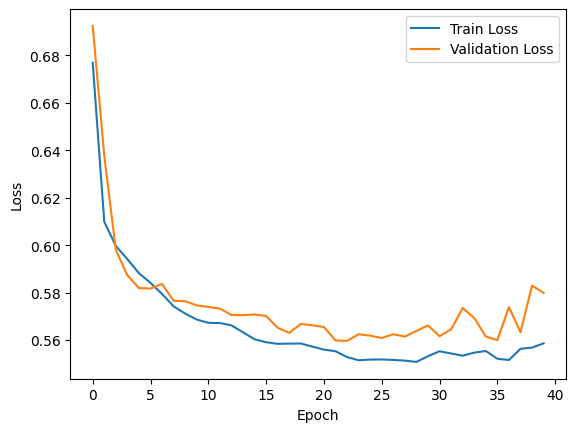

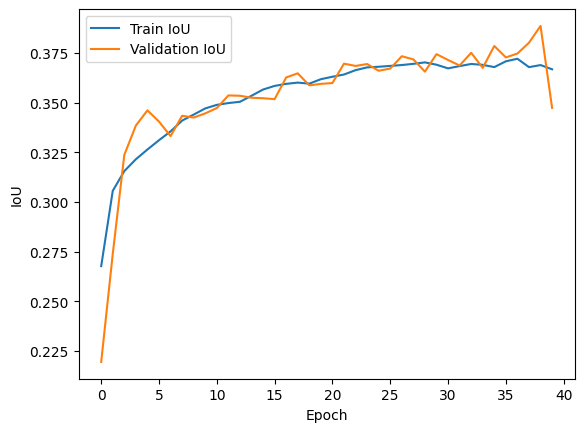

In [95]:
# Optionally, plot the training and validation loss curves
plt.plot(train_loss_history_2, label='Train Loss')
plt.plot(val_loss_history_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Optionally, plot the training and validation IoU curves
plt.plot(train_iou_history_2, label='Train IoU')
plt.plot(val_iou_history_2, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

## Testing the Model

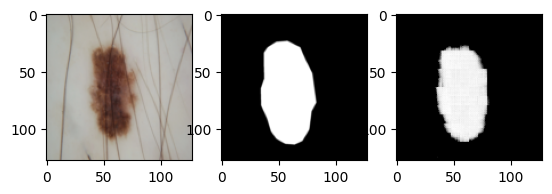

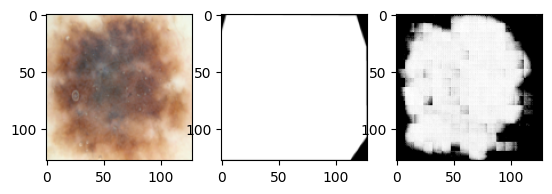

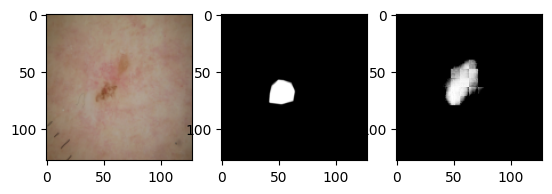

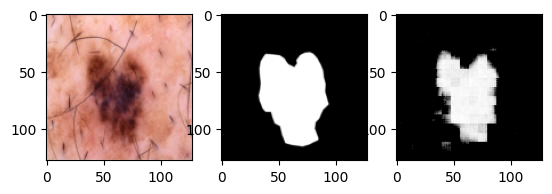

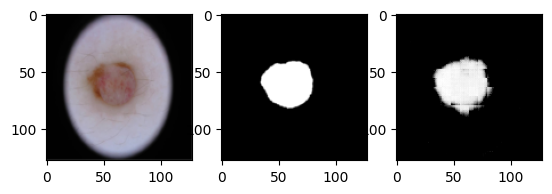

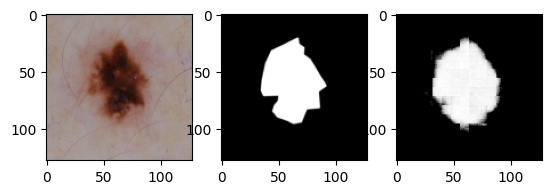

IoU tensor(0.3577, device='cuda:0')
Dice Score tensor(0.5265, device='cuda:0')


In [97]:
segmentation_model2.eval()
# evaluate the model on the test data
loss_2 = 0
iou_2 = 0
dice_2 = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = segmentation_model2(inputs)
#         outputs = 
        
        loss_2 += criterion(outputs, labels).item()
        iou_2 += compute_iou(outputs, labels)
        dice_2 += dice_coeff(outputs, labels)

        # visualize the predictions
        fig, axs = plt.subplots(1,3)
        axs[0].imshow(inputs[0].permute(1,2,0).cpu().numpy())
        axs[1].imshow(np.squeeze(labels[0].cpu().numpy()), cmap='gray')
        axs[2].imshow(outputs[0].permute(1,2,0).cpu().numpy(), cmap='gray')
#         print(outputs[0].permute(1,2,0).cpu().numpy().shape)
        plt.show()


# print(''?loss/len(test_loader))
print('IoU', iou_2/len(test_loader))
print('Dice Score', dice_2/len(test_loader))